# Methane satellite observations trend assessment for greenhouse gas monitoring

Production date: 26-05-2025

Produced by: CNR

## 🌍 Use case: Using satellite observations for quantifying global trends in greenhouse gas concentrations

## ❓ Quality assessment question
* **How the variability of spatial and temporal data coverage can affect the quantification of the long-term atmospheric methane trends by satellite measurements (XCH$_4$ Level 3 gridded product)?**

Methane (CH$_4$) is the second most important anthropogenic greenhouse gas after carbon dioxide (CO$_2$), representing about 19% of the total radiative forcing by long-lived greenhouse gases [[1]](https://library.wmo.int/records/item/68532-no-19-15-november-2023). Atmospheric CH$_4$ also adversely affects human health as a precursor of tropospheric ozone [[2]](https://doi.org/10.1073/pnas.0600201103). Monitoring the long-term CH$_4$ variability is therefore crucial for monitoring the emission reductions [[3]](https://doi.org/10.5194/essd-2024-115). In this assessment, atmospheric CH$_4$ spatial seasonal means and trends are analysed using the XCH$_4$ Level 3 gridded product (Obs4MIPs, version 4.5 [[4]](https://wdc.dlr.de/C3S_312b_Lot2/Documentation/GHG/C3S2_312a_Lot2_PUGS_GHG_main_latest.pdf)), by adopting an approach similar to [[5]](https://amt.copernicus.org/articles/13/789/2020/).

Code is included for transparency but also learning purposes and gives users the chance to adapt the code used for the assesment as they wish. Since this assessment is an experimental product, users are referred to official sources for accurate reporting (e.g., [[6]](https://climate.copernicus.eu/esotc/2024), [[7]](https://climate.copernicus.eu/global-climate-highlights-2024)). 

## 📢 Quality assessment statements

```{admonition} These are the key outcomes of this assessment
:class: note
* The dataset "Methane data from 2002 to present derived from satellite observations" can be used to evaluate CH$_4$ mean values, climatology and growth rate over the globe, hemispheres or large regions
* Caution should be exercised in certain regions (high latitudes, regions with frequent cloud cover, oceans) where data availability varies along the temporal coverage of the dataset: this must be carefully considered when evaluating global or hemispheric information
* For data in high latitude regions or in regions with frequent cloud cover, users should consult uncertainty and quality flags as appropriate for their applications. In addition, for the years 2003-2008 only values over land are available, which has to be taken into account for possible applications of this dataset
```

## 📋 Methodology

Spatial seasonal means and trends are presented and assessed using the XCH$_4$ v4.5 Level 3 gridded product (Obs4MIPs), which has been generated using the Level 2 EMMA products [[4]](https://wdc.dlr.de/C3S_312b_Lot2/Documentation/GHG/C3S2_312a_Lot2_PUGS_GHG_main_latest.pdf) as input. 

To show how data coverage varies between years and seasons, we have calculated and plotted the average XCH$_4$ values for the different seasons and years, over the period 2013-2022.

Spatial trends are calculated using a linear model (i.e., Theil-Sen slope estimator) over monthly anomalies (i.e., actual monthly values minus climatological monthly means). This should be treated with caution as the long-term trend of atmospheric CH$_4$ is not strictly linear. The statistical significance of the trends is assessed using the Mann-Kendall test. Similar to [[5]](https://amt.copernicus.org/articles/13/789/2020/), only land pixels are considered to avoid artefacts related to different data availability over oceans (the data product is land only for 2003-2008).

The time series of XCH$_4$, considering the entire dataset, is also shown, for highlighting the overall increasing trend. Please note that this analysis can be extended to three additional variables, not shown here ("xch4_stderr", "xch4_stddev" and "xch4_nobs"), or can be customized by the user for specific regions of interest.

The analysis and results are organised in the following steps, which are detailed in the sections below:

**[](template:section-1)**
 * Import all the relevant packages.
 * Choose the temporal and spatial coverage, land mask, and possible spatial regions for the analysis.
 * Cache needed functions.

**[](template:section-2)**
 * In this section, we define the data request to CDS.

**[](template:section-3)**
 * To show how data coverage varies between years and seasons, we have plotted spatial average XCH$_4$ values for seasons and years. To avoid the production of too many maps, this analysis has been limited to the period 2013-2022. Seasons are defined as December-February (DJF), March-May (MAM), June-August (JJA) and September-November (SON).

**[](template:section-4)**
 * Trends (over 2013-2022) are calculated using a linear model (i.e., Theil-Sen slope estimator) over monthly anomalies (i.e., actual monthly values minus climatological monthly means). The statistical significance of the trends is assessed using the Mann-Kendall test.

**[](template:section-5)**
 * The global time series of XCH$_4$ over the entire data period (2003-2023) is shown.

## 📈 Analysis and results

(template:section-1)=
### 1. Choose the data to use and set-up the code

#### Import all relevant packages
In this section, we import all the relevant packages needed for running the notebook.

In [1]:
import math
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
from c3s_eqc_automatic_quality_control import diagnostics, download, plot, utils
from xarrayMannKendall import Mann_Kendall_test

plt.style.use("seaborn-v0_8-notebook")
plt.rcParams["hatch.linewidth"] = 0.5 

import os
os.environ["CDSAPI_RC"] = os.path.expanduser("~/putero_davide/.cdsapirc")

#### Choose temporal and spatial coverage, land mask
In this section, we define the parameters to be ingested by the code (that can be customized by the user), i.e.: 
* the temporal period of analysis;
* the activation/deactivation of the land masking;
* the regions selected for the analysis. Please note that, for this notebook, only the global maps and time series are reported.

The analyses presented in this notebook cover different time periods:
* with the aim to compare our results with existing literature [[1]](https://library.wmo.int/records/item/68532-no-19-15-november-2023), the global variability and trend analyses are limited to 2013-2022;
* the time series of XCH$_4$ covers the entire period of data coverage.

In [2]:
# Choose variable
variable = "xch4"
assert variable in [
    f"{prefix}{suffix}"
    for prefix in ("xch4", "xco2")
    for suffix in ("", "_nobs", "_stderr", "_stddev")
]

# Choose a time period (to be used for the global variability and trend analysis)
year_start = 2013
year_stop = 2022

# Minimum value of land fraction used for masking
min_land_fraction = 0.5 # Use None to switch off

# Define regions for analysis
lon_slice = slice(-180, 180)
lat_slice = slice(-90, 90)

regions = {
    "global": {"lon_slice": slice(-180, 180), "lat_slice": slice(-90, 90)}
}

#### Chache needed functions
In this section, we cached a list of functions used in the analyses.

- The function `get_da` (`get_da_nomask`) is used to subset the data for the defined time period and spatial region by applying (not appliyng) the land mask (as a function of *min_land_fraction*).

- The function `convert_units` rescales XCH$_4$ mole fraction to parts per billion (ppb).

- The `seasonal_weighted_mean` function extracts the regional means over the selected domains. It uses spatial weighting to account for the latitudinal dependence of the grid size in the lon/lat grids used for the reanalysis and for the forecast models. It is used by the function `compute_seasonal_timeseries_nomask` to provide the seasonal XCH$_4$ average value for each year (Fig. 1). 

- The function `compute_anomaly_trends` is used to calculate the trend and the related statistical significance. 

- The `compute_monthly_anomalies` function is used to derive the monthly XCH$_4$ anomalies before calculating the trends.

- The `mask_scale_and_regionalise` function extracts the XCH$_4$ data over the selected spatial region. It uses spatial weighting to account for the latitudinal dependence of the grid size in the lon/lat grids used for the reanalysis and for the forecast models. It uses the `convert_units` function for rescaling the values to ppb, and it applies the threshold (if any) on the minimum land fraction.

In [4]:
transform_func_kwargs = {
    "min_land_fraction": min_land_fraction,
    "variable": variable,
    "year_start": year_start,
    "year_stop": year_stop,
    "lon_slice": lon_slice,
    "lat_slice": lat_slice,
}

transform_func_kwargs_nommask = {
    "year_start": year_start,
    "year_stop": year_stop,
}

def convert_units(da):
    if da.name.endswith("_nobs"):
        return da

    with xr.set_options(keep_attrs=True):
        if da.name.startswith("xch4") and da.attrs["units"] != "ppb":
            da *= 1.0e9
            da.attrs["units"] = "ppb"
        elif da.name.startswith("xco2") and da.attrs["units"] != "ppm":
            da *= 1.0e6
            da.attrs["units"] = "ppm"
    return da


def mask_scale_and_regionalise(ds, min_land_fraction, lon_slice, lat_slice):
    if min_land_fraction is not None:
        ds = ds.where(ds["land_fraction"] >= min_land_fraction)
    for var, da in ds.data_vars.items():
        if (fill_value := da.attrs.pop("fill_value", None)) is not None:
            da = da.where(da != fill_value.astype(da.dtype))
        ds[var] = convert_units(da)
    if lon_slice or lat_slice:
        ds = utils.regionalise(ds, lon_slice=lon_slice, lat_slice=lat_slice)
    return ds


def get_da(
    ds, min_land_fraction, variable, year_start, year_stop, lon_slice, lat_slice
):
    ds = mask_scale_and_regionalise(
        ds.sel(time=slice(str(year_start), str(year_stop))),
        min_land_fraction,
        lon_slice,
        lat_slice,
    )
    da = ds[variable]
    da = utils.regionalise(da, lon_slice=lon_slice, lat_slice=lat_slice)
    if min_land_fraction is not None:
        return da.where(ds["land_fraction"] >= min_land_fraction)
    return da


def get_da_nomask(ds, year_start, year_stop):
    mask = (ds["time"].dt.year >= year_start) & (ds["time"].dt.year <= year_stop)
    ds = ds.where(mask.compute(), drop=True)
    ds = mask_scale_and_regionalise(ds, None, None, None)
    (varname,) = set(ds.data_vars) & {"xch4"}
    da = ds[varname]
    return da


def compute_seasonal_timeseries_nomask(ds, year_start, year_stop):
    # Shift years (shift -1 to get D(year-1)J(year)F(year))
    da = get_da_nomask(ds, year_start, year_stop)
    da = da.assign_coords(year=ds["time"].dt.year.shift(time=-1).astype(int))
    # Get rid of 1st JF and last D, so it become [MAM, JJA, SON, DJF, ..., SON]
    da = da.isel(time=slice(2, -1))
    da = da.groupby("year").map(diagnostics.seasonal_weighted_mean)
    return da.to_dataset()


def compute_statistics(ds, **get_da_kwargs):
    da = get_da(ds, **get_da_kwargs)
    da = diagnostics.spatial_weighted_statistics(da)
    return da.to_dataset()


def compute_monthly_anomalies(ds, **get_da_kwargs):
    da = get_da(ds, **get_da_kwargs)
    with xr.set_options(keep_attrs=True):
        da = da.groupby("time.month") - da.groupby("time.month").mean()
    return da


def compute_mann_kendall_trend(da, **mann_kendall_kwargs):
    coords_name = {"time": "time", "x": "longitude", "y": "latitude"}
    ds_trend = Mann_Kendall_test(
        da, coords_name=coords_name, **mann_kendall_kwargs
    ).compute()
    return ds_trend.rename({k: v for k, v in coords_name.items() if k != "time"})


def compute_seasonal_detrended_anomaly(da, **polyfit_kwargs):
    da_trend = xr.polyval(
        da["time"], da.polyfit("time", **polyfit_kwargs).polyfit_coefficients
    )
    da_detrended = da - da_trend
    return da_detrended.groupby("time.year").map(diagnostics.seasonal_weighted_mean)


def compute_anomaly_trends(ds, **get_da_kwargs):
    da_anomaly = compute_monthly_anomalies(ds, **get_da_kwargs)

    # Mann-Kendall
    ds_mann_kendall = compute_mann_kendall_trend(
        da_anomaly, alpha=0.05, method="theilslopes"
    ).where(da_anomaly.notnull().any("time"))
    ds_mann_kendall["trend"].attrs = {
        "long_name": f"Trend of anomalies of {da_anomaly.attrs.get('long_name', da_anomaly.name)}",
        "units": f"{da_anomaly.attrs['units']}/month",
    }

    # Detrended anomalies
    da_detrended = compute_seasonal_detrended_anomaly(da_anomaly, deg=1)
    da_detrended.attrs = {
        "long_name": f"Detrended of anomalies of {da_anomaly.attrs.get('long_name', da_anomaly.name)}",
        "units": f"{da_anomaly.attrs['units']}",
    }

    ds_mann_kendall["detrended_anomaly"] = da_detrended
    return ds_mann_kendall

(template:section-2)=
### 2. Retrieve XCH$_4$ data (Obs4MIPs)
In this section, we define the data request to CDS (data product Obs4MIPs, Level 3, version 4.5, XCH$_4$) and download the dataset.

In [3]:
request = (
    "satellite-carbon-dioxide" if variable.startswith("xco2") else "satellite-methane",
    {
        "processing_level": "level_3",
        "variable": variable.split("_")[0],
        "sensor_and_algorithm": "merged_obs4mips",
        "version": "4_5",
        "format": "zip",
    },
)

In [5]:
datasets = {}
for region, kwargs in regions.items():
    print(f"{region=}")
    ds = download.download_and_transform(
        *request,
        transform_func=mask_scale_and_regionalise,
        transform_func_kwargs={"min_land_fraction": min_land_fraction} | kwargs,
    )
    for da in ds.data_vars.values():
        if da.attrs.get("units") in ["1", 1]:
            da.attrs.pop("units")
    datasets[region] = ds

region='global'


100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


(template:section-3)=
### 3. Compute and plot the global variability of seasonal XCH$_4$
To show how data coverage varies between years and seasons, in this section we plot the spatial average XCH$_4$ values for seasons and years. To limit the number of plots produced, this analysis is limited to the period 2013-2022. Seasons are defined as: December-February (DJF), March-May (MAM), June-August (JJA), and September-November (SON). The seasonality of the availability of measurements is evident, with values available in the Southern Hemisphere (SH) mid and high latitudes from September to March, whereas values for the Northern Hemisphere (NH) mid and high latitudes are mostly available from April to August (Fig. 1).

100%|██████████| 1/1 [00:00<00:00, 15.67it/s]


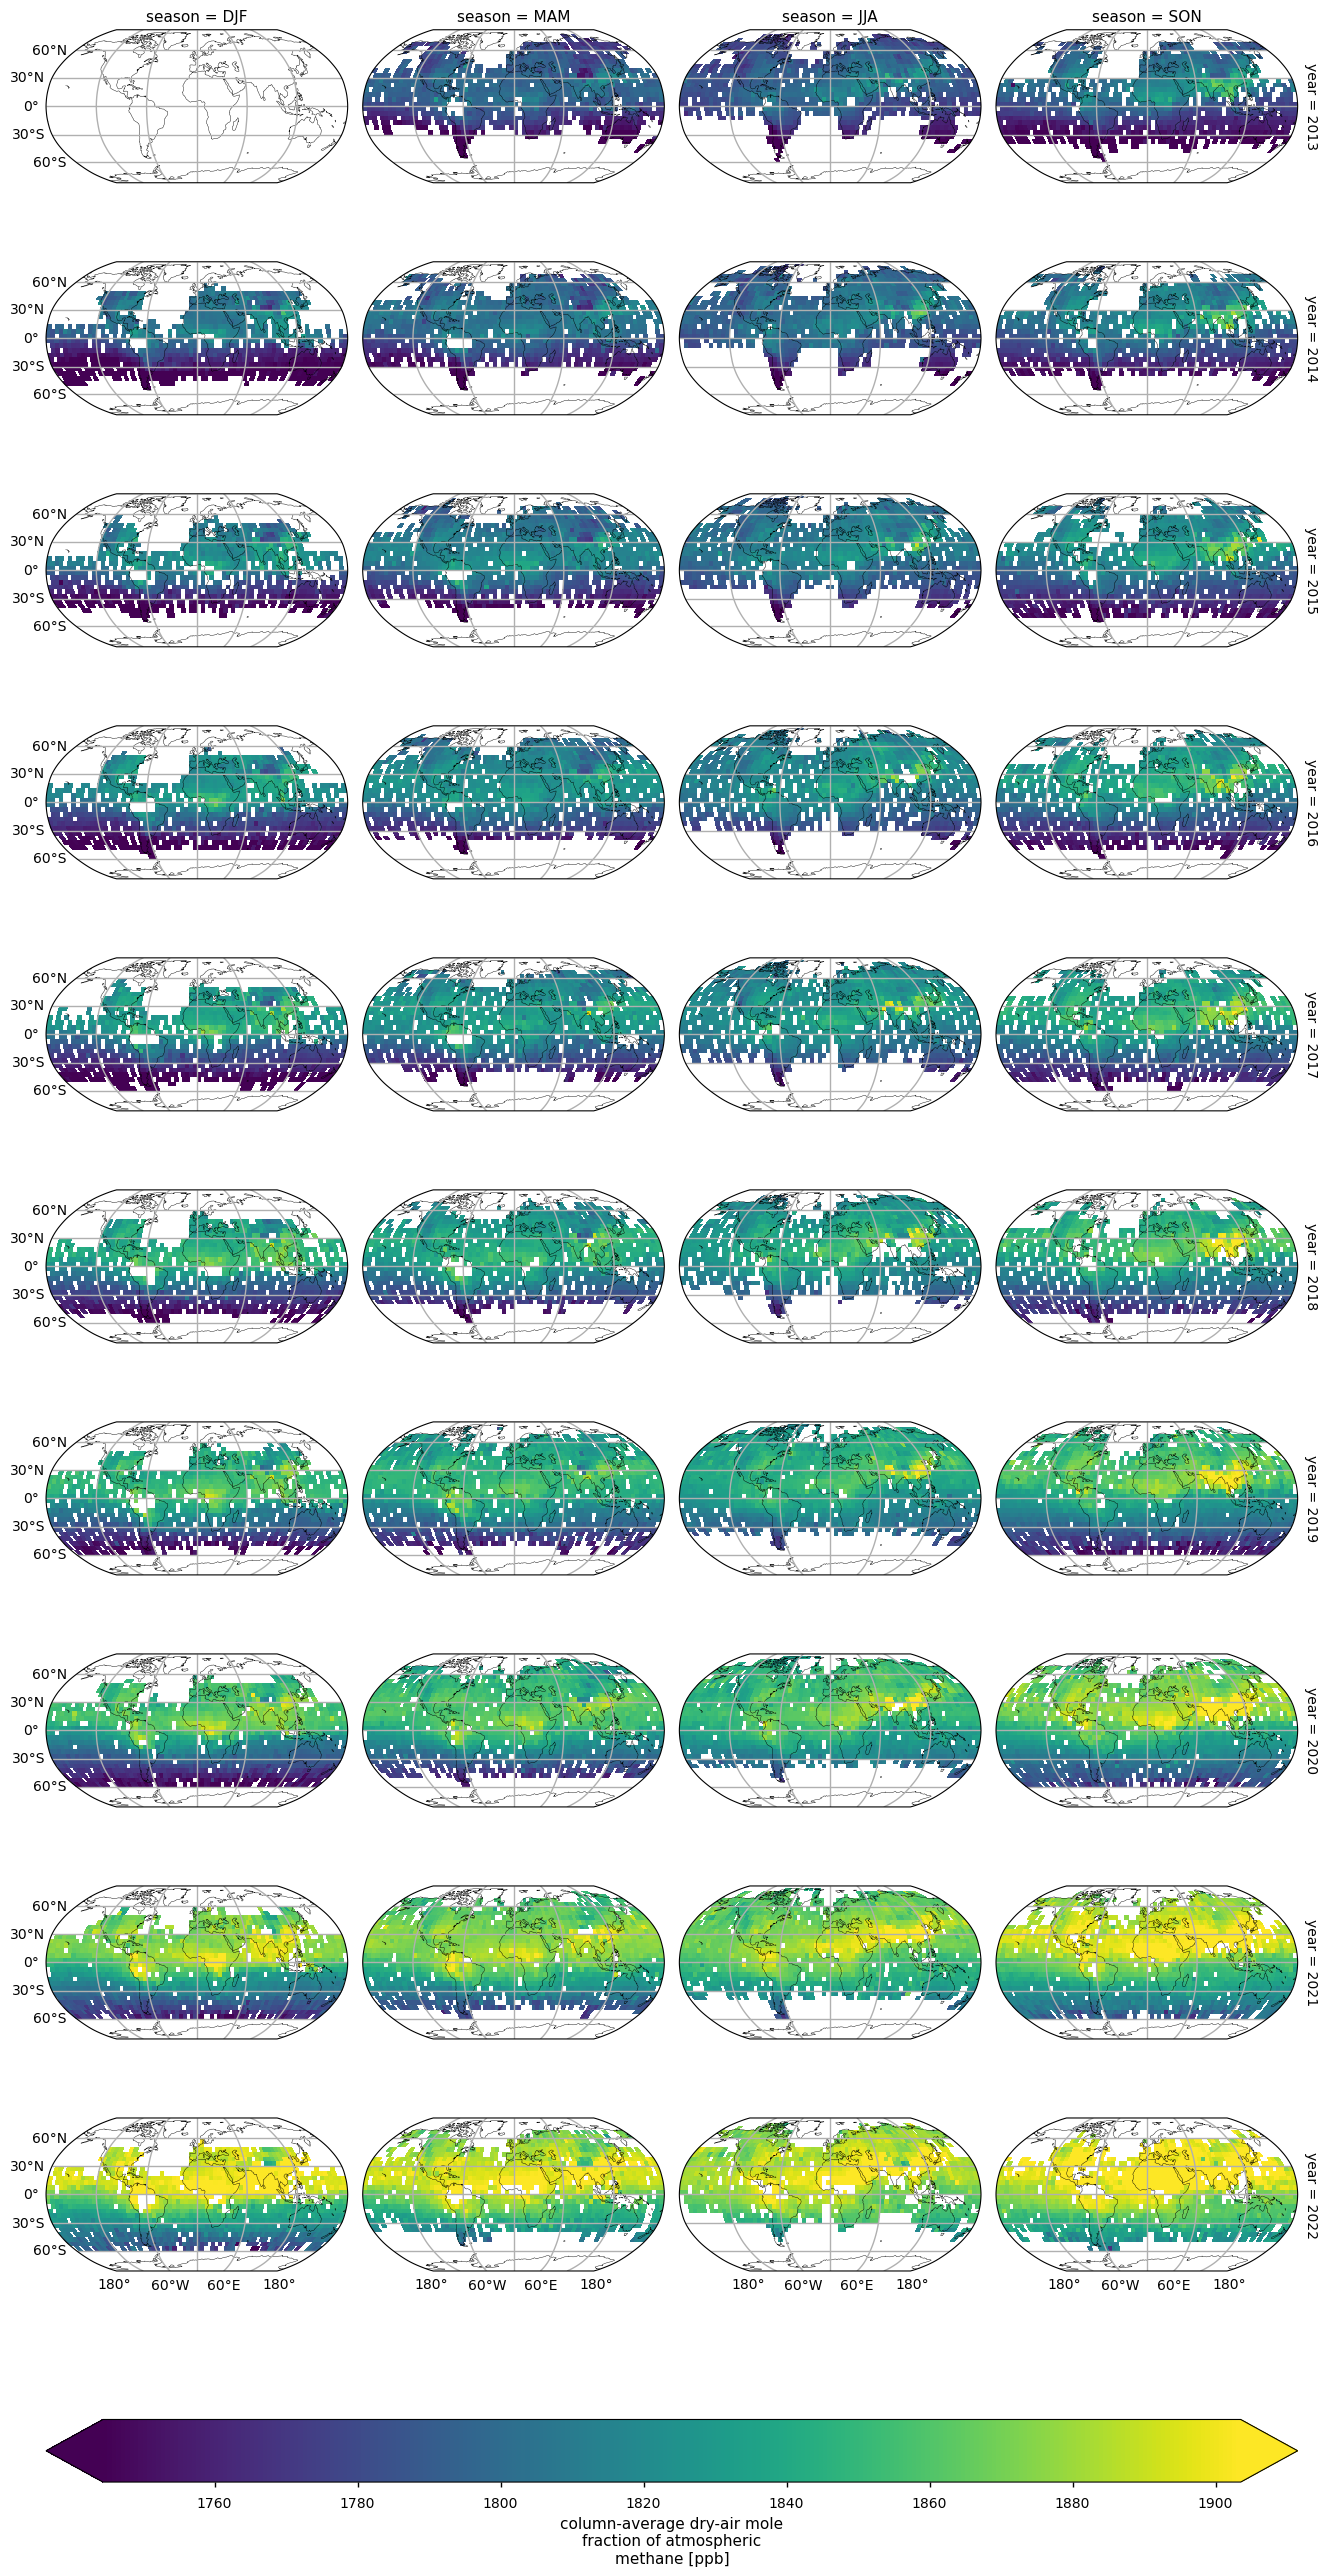

In [6]:
#Analysis of global variability of seasonal XCH4
#To invalidate the cache you can pass the argument invalidate_cache=True

ds_seasonal = download.download_and_transform(
    *request,
    transform_func=compute_seasonal_timeseries_nomask,
    transform_func_kwargs=transform_func_kwargs_nommask,
)
da = ds_seasonal[variable].sel(season=["DJF", "MAM", "JJA", "SON"])
_ = plot.projected_map(
    da,
    projection=ccrs.Robinson(),
    col="season",
    row="year",
    robust=True,
    cbar_kwargs={"orientation": "horizontal", "pad": 0.05},
)

*Figure 1. Global annual variability of seasonal XCH$_4$, over 2013-2022. The different panels represent the individual seasons (column) and years (rows). Seasons are defined as: December-February (DJF), March-May (MAM), June-August (JJA), and September-November (SON).*

(template:section-4)=
### 4. Compute global and spatial trends

In this section, XCH$_4$ spatial trends are calculated and statistical significance is assessed for land pixels ("land_fraction > 0.5"). Global statistics for individual pixels are also reported as ppb/month. Please note that the low growth rates observed in the tropics are probably a result of sparse data availability due to the frequent presence of clouds. 

For 2013-2022, the mean global XCH$_4$ growth rate is 9.71 ppb/yr (Fig. 2). Taking into account the associated uncertainties and the different calculation methods as well as the different nature of the dataset, this value is in good agreement with the value of the mean absolute increase over the past 10 years provided by the WMO global in-situ observations, i.e., 10.20 ppb/yr [[1]](https://library.wmo.int/records/item/68532-no-19-15-november-2023).

100%|██████████| 1/1 [00:00<00:00, 18.31it/s]


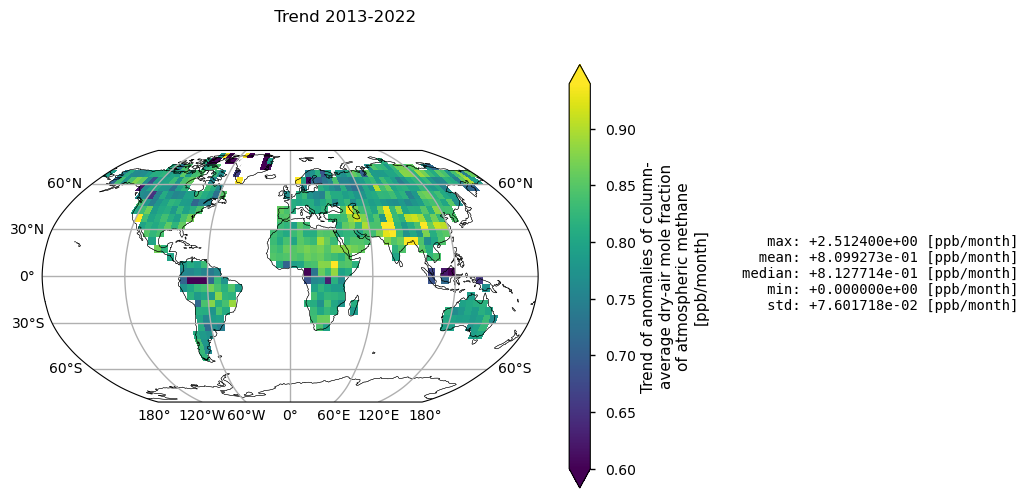

In [7]:
#Calculation of global and pixel trends
#To invalidate the cache you can pass the argument invalidate_cache=True
ds_trend = download.download_and_transform(
    *request,
    transform_func=compute_anomaly_trends,
    transform_func_kwargs=transform_func_kwargs,
)

plot.projected_map(ds_trend["trend"], robust=True, projection=ccrs.Robinson())
plot.projected_map(
    ds_trend["p"],
    plot_func="contourf",
    show_stats=False,
    cmap="none",
    add_colorbar=False,
    levels=[0, 0.05, 1],
    hatches=["", "/" * 5],
)
_ = plt.suptitle(
    f" Trend {year_start}-{year_stop}"
)

*Figure 2. Trends of XCH$_4$ given in ppb/month calculated by using linear model (Theil-Sen) and Mann-Kendall test for statistical significance. Over each pixel, trends are calculated for monthly anomalies over land ("land_fraction > 0.5"). The shaded areas indicate pixels that did not pass the Mann-Kendall significance test. Global statistics for individual pixels are shown on the right of the plot.*

(template:section-5)=
### 5. Time series for global XCH$_4$

In this section, we show the time series for XCH$_4$, considering the entire dataset (Fig. 3). The plot displays the monthly global spatial average, along with the corresponding monthly standard deviation.

The v4.5 Level 3 gridded product (Obs4MIPs) provides global long-term XCH$_4$ variability which is in agreement with other global datasets (e.g., [[1]](https://library.wmo.int/records/item/68532-no-19-15-november-2023)). In particular, XCH$_4$ values have been nearly constant until 2007, then a positive trend has been detected. This is likely due to a combination of increasing natural (e.g., wetlands) and anthropogenic (e.g., fossil-fuel related) emissions, and possible decreasing sinks, although this is currently under investigation (see [[5]](https://amt.copernicus.org/articles/13/789/2020/) and references therein).

Please note that this analysis can be customized by the user to limit it to specific regions, or to include three additional variables (not shown here): 
* "xch4_stderr", which indicates the reported uncertainty defined as the standard error of the average including single sounding noise and potential seasonal and regional biases;
* "xch4_stddev", which represents the standard deviation of the XCH$_4$ Level 2 observations within each grid box; 
* "xch4_nobs", which denotes the number of individual XCH$_4$ Level 2 observations used to compute the monthly Level 3 data.

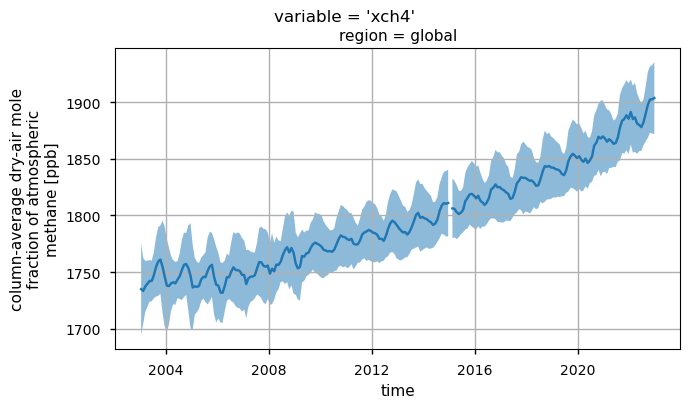

In [8]:
for variable in ["xch4"]:
    means = []
    stds = []
    for region, ds in datasets.items():
        da = ds[variable]
        means.append(diagnostics.spatial_weighted_mean(da).expand_dims(region=[region]))
        stds.append(diagnostics.spatial_weighted_std(da).expand_dims(region=[region]))
    da_mean = xr.concat(means, "region")
    da_std = xr.concat(stds, "region")

    facet = da_mean.plot(col="region", figsize=(7, 4))
    for ax, sel_dict in zip(facet.axs.flatten(), facet.name_dicts.flatten()):
        lower = da_mean.sel(sel_dict) - da_std.sel(sel_dict)
        ax.fill_between(
            da["time"],
            lower.where(lower > 0, 0),
            da_mean.sel(sel_dict) + da_std.sel(sel_dict),
            alpha=0.5,
        )
        ax.grid()
    facet.fig.suptitle(f"{variable = }", y=1.01)
    plt.show()

*Figure 3. Global monthly time series of XCH$_4$ for the entire dataset. The blue lines represents the monthly spatial average, while the shaded areas indicate $\pm$1 standard deviation. The main title indicates the variable shown, while the subtitle specifies the corresponding region.*

## ℹ️ If you want to know more

### Key resources

The CDS catalogue entries for the data used were:
* Methane data from 2002 to present derived from satellite observations: https://cds.climate.copernicus.eu/datasets/satellite-methane?tab=overview

Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [B-Open](https://www.bopen.eu/)

### References
[[1]](https://library.wmo.int/records/item/68532-no-19-15-november-2023) World Meteorological Organization (2023). WMO Greenhouse Gas Bulletin, No. 19, ISSN 2078-0796.

[[2]](https://doi.org/10.1073/pnas.0600201103) West, J. J., Fiore, A. M., Horowitz, L. W., and Mauzerall, D. L. (2006). Global health benefits of mitigating ozone pollution with methane emission controls. Proceedings of the National Academy of Sciences USA, 103, 3988–3993.

[[3]](https://doi.org/10.5194/essd-2024-115) Saunois, M., Martinez, A., Poulter, B., Zhang, Z., Raymond, P., Regnier, P., Canadell, J. G., Jackson, R. B., Patra, P. K., Bousquet, P., Ciais, P., Dlugokencky, E. J., Lan, X., Allen, G. H., Bastviken, D., Beerling, D. J., Belikov, D. A., Blake, D. R., Castaldi, S., Crippa, M., Deemer, B. R., Dennison, F., Etiope, G., Gedney, N., Höglund-Isaksson, L., Holgerson, M. A., Hopcroft, P. O., Hugelius, G., Ito, A., Jain, A. K., Janardanan, R., Johnson, M. S., Kleinen, T., Krummel, P., Lauerwald, R., Li, T., Liu, X., McDonald, K. C., Melton, J. R., Mühle, J., Müller, J., Murguia-Flores, F., Niwa, Y., Noce, S., Pan, S., Parker, R. J., Peng, C., Ramonet, M., Riley, W. J., Rocher-Ros, G., Rosentreter, J. A., Sasakawa, M., Segers, A., Smith, S. J., Stanley, E. H., Thanwerdas, J., Tian, H., Tsuruta, A., Tubiello, F. N., Weber, T. S., van der Werf, G., Worthy, D. E., Xi, Y., Yoshida, Y., Zhang, W., Zheng, B., Zhu, Q., Zhu, Q., and Zhuang, Q. (2024). Global Methane Budget 2000–2020, Earth System Science Data Discussion, in review.

[[4]](https://wdc.dlr.de/C3S_312b_Lot2/Documentation/GHG/C3S2_312a_Lot2_PUGS_GHG_main_latest.pdf) Buchwitz, M. (2024). Product User Guide and Specification (PUGS) – Main document for Greenhouse Gas (GHG: CO$_2$ & CH$_4$) data set CDR7 (01.2003-12.2022), C3S project 2021/C3S2_312a_Lot2_DLR/SC1, v7.3.

[[5]](https://amt.copernicus.org/articles/13/789/2020/) Reuter, M., Buchwitz, M., Schneising, O., Noël, S., Bovensmann, H., Burrows, J. P., Boesch, H., Di Noia, A., Anand, J., Parker, R. J., Somkuti, P., Wu, L., Hasekamp, O. P., Aben, I., Kuze, A., Suto, H., Shiomi, K., Yoshida, Y., Morino, I., Crisp, D., O'Dell, C. W., Notholt, J., Petri, C., Warneke, T., Velazco, V. A., Deutscher, N. M., Griffith, D. W. T., Kivi, R., Pollard, D. F., Hase, F., Sussmann, R., Té, Y. V., Strong, K., Roche, S., Sha, M. K., De Mazière, M., Feist, D. G., Iraci, L. T., Roehl, C. M., Retscher, C., and Schepers, D. (2020). Ensemble-based satellite-derived carbon dioxide and methane column-averaged dry-air mole fraction data sets (2003–2018) for carbon and climate applications, Atmospheric Measurement Techniques, 13, 789–819.

[[6]](https://climate.copernicus.eu/esotc/2024) Copernicus Climate Change Service (C3S). (2024). European State of the Climate 2023, Full report.

[[7]](https://climate.copernicus.eu/global-climate-highlights-2024) Copernicus Climate Change Service (C3S). (2024). Global Climate Highlights 2023.